This Colab notebook has reference to https://github.com/anjanatiha/Pneumonia-Detection-from-Chest-X-Ray-Images-with-Deep-Learning

In [1]:
# check GPU infomation (K80, T4, P100)
!nvidia-smi

Mon May 25 09:23:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
#@title Download data and unzip the file
url = 'https://data.mendeley.com/datasets/rscbjbr9sj/2/files/f12eaf6d-6023-432f-acc9-80c9d7393433/ChestXRay2017.zip'
!wget {url}
!unzip -n -q 'ChestXRay2017.zip'
print("... done")

--2020-05-25 09:23:48--  https://data.mendeley.com/datasets/rscbjbr9sj/2/files/f12eaf6d-6023-432f-acc9-80c9d7393433/ChestXRay2017.zip
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86, 2606:4700:7::a29f:8256, ...
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/31ab5ede-ed34-46d4-b1bf-c63d70411497 [following]
--2020-05-25 09:23:50--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/31ab5ede-ed34-46d4-b1bf-c63d70411497
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.104.43
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.104.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1235512

In [60]:
#@title --import packages and modules
import os, glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# tensorflow.keras
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version =", tf.__version__)
from tensorflow.keras import layers, initializers, regularizers, optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical, plot_model

# pre-trained models from tensorflow.keras.applications (https://keras.io/applications/)
# from tensorflow.keras.applications.xception import Xception, preprocess_input
# from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input

# evaluation tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.utils import shuffle
from scipy.signal import resample
from scipy import interp
from itertools import cycle, product

Tensorflow version = 2.2.0


# 0 analyze image data

In [0]:
TRAIN_DIR = 'chest_xray/train'
TEST_DIR = 'chest_xray/test'

Number of Class:  2


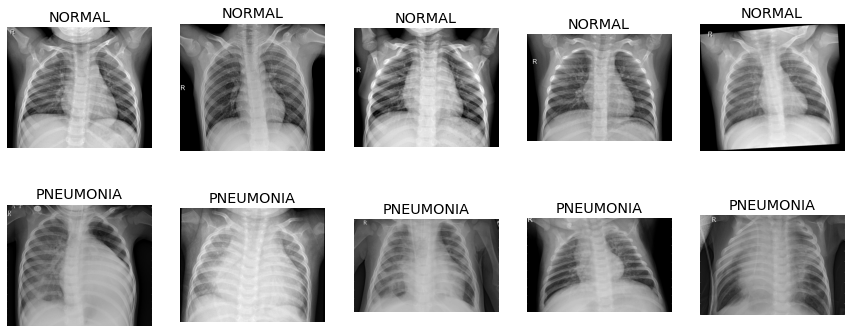

In [62]:
def show_class_sample_images(directory, image_count_per_category=5):
    classes = os.listdir(directory)
    classes = [c for c in classes if not c.startswith(".")]
    print("Number of Class: ", len(classes))
    img_list = []
    for class_name in classes:
        image_file_list = glob.glob(os.path.join(directory, class_name) + '/*.jpeg')
        image_file_arr = np.random.choice(image_file_list, size=image_count_per_category)
        for image_file in image_file_arr:
            img = Image.open(image_file)
            img_list.append(img)
    # plot
    fig=plt.figure(figsize=(15, 6))
    columns = image_count_per_category
    rows = len(classes)
    for i in range(columns*rows):
        img = img_list[i]
        class_name = classes[int(i//image_count_per_category)]
        fig.add_subplot(rows, columns, i+1)
        plt.title(class_name)
        plt.axis('off')
        plt.imshow(img, cmap='gray')
    plt.show()

    return classes

classes = show_class_sample_images(TRAIN_DIR, image_count_per_category=5)

In [63]:
def data_count_number(directory):
    classes = os.listdir(directory)
    classes = [c for c in classes if not c.startswith(".")]
    for class_name in classes:
        print("{:>20}/{:>10} ... number = {:>6}".format(directory, 
                                                        class_name, 
                                                        len(glob.glob(os.path.join(directory, class_name) + '/*.jpeg'))
                                                        ))
data_count_number(TRAIN_DIR)
data_count_number(TEST_DIR)

    chest_xray/train/    NORMAL ... number =   1349
    chest_xray/train/ PNEUMONIA ... number =   3883
     chest_xray/test/    NORMAL ... number =    234
     chest_xray/test/ PNEUMONIA ... number =    390


# 1 DataGenerator

In [64]:
#@title data augmentation settings

shear_range = 0.05 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
zoom_range = 0.05 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
width_shift_range = 0.05 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
height_shift_range = 0.05 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
rotation_range = 5 #@param {type:"slider", min:0, max:90, step:5}
horizontal_flip = True #@param {type:"boolean"}
vertical_flip = False #@param {type:"boolean"}

target_size = (150, 150)
batch_size = 12

train_datagen = ImageDataGenerator(
    shear_range=shear_range,
    zoom_range=zoom_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    rotation_range=rotation_range,
    horizontal_flip=horizontal_flip,
    vertical_flip=vertical_flip, 
    preprocessing_function=preprocess_input) 

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=target_size, 
                                                    batch_size=batch_size, 
                                                    shuffle=True)
train_steps_per_epoch = np.ceil(train_generator.n / batch_size)
print("train_steps_per_epoch =", train_steps_per_epoch)

# Data Generator for validation without data augmentation!
test_datagen   = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(TEST_DIR, 
                                                  target_size=target_size, 
                                                  batch_size=batch_size, 
                                                  shuffle=False)
test_steps_per_epoch = np.ceil(test_generator.n / batch_size)
print("test_steps_per_epoch =", test_steps_per_epoch)

Found 5232 images belonging to 2 classes.
train_steps_per_epoch = 436.0
Found 624 images belonging to 2 classes.
test_steps_per_epoch = 52.0


X_batch shape: (12, 150, 150, 3) 	y_batch shape: (12, 2)


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


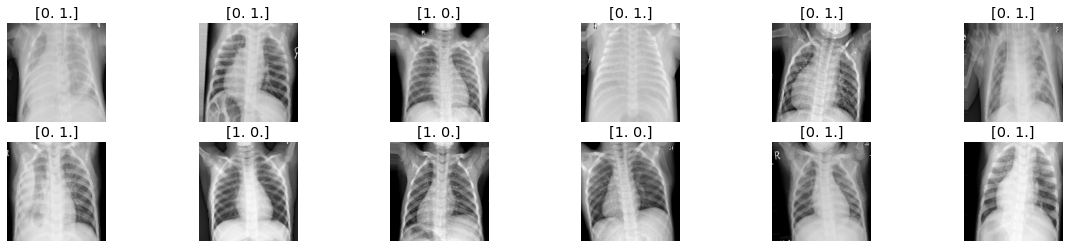

In [65]:
#@title Plot some training data from train_generator
X_batch, y_batch = train_generator.next()
print("X_batch shape:", X_batch.shape, "\ty_batch shape:", y_batch.shape)

fig=plt.figure(figsize=(20, 4))
columns = 6
rows = 2
for i in range(columns*rows):
    img = X_batch[i]
    fig.add_subplot(rows, columns, i+1)
    plt.title(y_batch[i])
    plt.axis('off')
    plt.imshow(img[:,:,0], cmap='gray')  # show R channel
plt.show()

In [66]:
#@title get training class_weight
from sklearn.utils import class_weight
def get_weight(y):
    class_weight_current =  class_weight.compute_class_weight('balanced', np.unique(y), y)
    return {i:w for i, w in enumerate(class_weight_current)}

class_weight = get_weight(train_generator.classes)
class_weight

{0: 1.939214232765011, 1: 0.6737058975019315}

# 2 Model

In [89]:
#@title build transfer learing model
# https://keras.io/applications/
K.clear_session()

base_model = ResNet50V2(include_top=False, 
                      weights='imagenet', 
                      input_shape=(target_size[0], target_size[1], 3), 
                      pooling='avg')
base_model.trainable = False  # freeze base_model

from keras.layers import Flatten
model = Sequential()
model.add(base_model)
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.05))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(len(classes), activation='softmax'))  # len(classes) <-- number of classes

model._name = 'ResNet50V2_D32_D2'  # <-- custom model name
model.summary()

Model: "ResNet50V2_D32_D2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 32)                65568     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 23,631,490
Trainable params: 66,690
Non-trainable params: 23,564,800
_________________________________________________________________


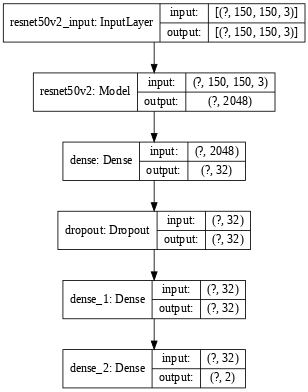

In [90]:
#@title plot model
plot_model(model, to_file="model_plot.png", show_shapes=True, dpi=60)

## compile model
for regression task

In [0]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# 3 Training

In [92]:
#@title Run training
# https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

epochs = 10 #@param {type:"number"}

''' use class_weight, This can be useful to tell the model to 
"pay more attention" to samples from an under-represented class.'''
print('class_weight:', class_weight)

history = model.fit(train_generator, 
                    steps_per_epoch=train_steps_per_epoch, 
                    epochs=epochs, 
                    validation_data=test_generator, 
                    validation_steps=test_steps_per_epoch, 
                    class_weight=class_weight)  # use class_weight

class_weight: {0: 1.939214232765011, 1: 0.6737058975019315}
Epoch 1/10
436/436 [==============================] - 105s 241ms/step - loss: 0.2203 - accuracy: 0.9094 - val_loss: 0.3307 - val_accuracy: 0.8734
Epoch 2/10
436/436 [==============================] - 104s 238ms/step - loss: 0.1466 - accuracy: 0.9434 - val_loss: 0.3783 - val_accuracy: 0.8446
Epoch 3/10
436/436 [==============================] - 104s 238ms/step - loss: 0.1311 - accuracy: 0.9451 - val_loss: 0.4936 - val_accuracy: 0.8542
Epoch 4/10
436/436 [==============================] - 105s 240ms/step - loss: 0.1287 - accuracy: 0.9511 - val_loss: 0.3712 - val_accuracy: 0.8686
Epoch 5/10
436/436 [==============================] - 104s 239ms/step - loss: 0.1196 - accuracy: 0.9545 - val_loss: 0.4499 - val_accuracy: 0.8718
Epoch 6/10
436/436 [==============================] - 103s 237ms/step - loss: 0.1102 - accuracy: 0.9534 - val_loss: 0.3401 - val_accuracy: 0.8766
Epoch 7/10
436/436 [==============================] - 104s 239ms

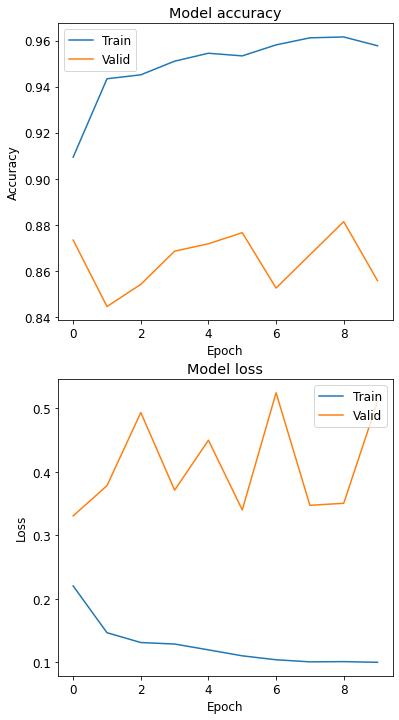

In [93]:
# Training history visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,12))

# Plot training & validation accuracy values
ax1.plot(history.history['accuracy'])  # fix
ax1.plot(history.history['val_accuracy'])  # fix
ax1.set_title('Model accuracy')
ax1.set(ylabel='Accuracy', xlabel='Epoch')
ax1.legend(['Train', 'Valid'], loc='upper left')

# Plot training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set(ylabel='Loss', xlabel='Epoch')
ax2.legend(['Train', 'Valid'], loc='upper right')

plt.savefig('train_history.png', dpi=72)  # <-- save plot
plt.show()

# 4 Evaluation

In [94]:
#@title re-initialize test_generator
test_generator = test_datagen.flow_from_directory(TEST_DIR, 
                                                 target_size=target_size,
                                                 batch_size=batch_size,
                                                 shuffle=False)
test_steps_per_epoch = np.ceil(test_generator.n / batch_size)
print("test_steps_per_epoch =", test_steps_per_epoch)

# 取得正確答案 (y_test)
y_test = test_generator.labels
y_test = to_categorical(y_test)  # as one-hot encoding

print("CLASSES:", classes)
print("y_test:", y_test.shape)
print(y_test)

Found 624 images belonging to 2 classes.
test_steps_per_epoch = 52.0
CLASSES: ['NORMAL', 'PNEUMONIA']
y_test: (624, 2)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [95]:
#@title 開始模型預測
y_pred = model.predict(test_generator, 
                       steps=test_steps_per_epoch, 
                       verbose=1)
print("y_pred shape =", y_pred.shape)
np.set_printoptions(precision=4, suppress=True)
print(y_pred)

52/52 [==============================] - 7s 137ms/step
y_pred shape = (624, 2)
[[0.2808 0.7192]
 [0.9857 0.0143]
 [0.6287 0.3713]
 ...
 [0.     1.    ]
 [0.0001 0.9999]
 [0.0013 0.9987]]


<Figure size 432x288 with 0 Axes>

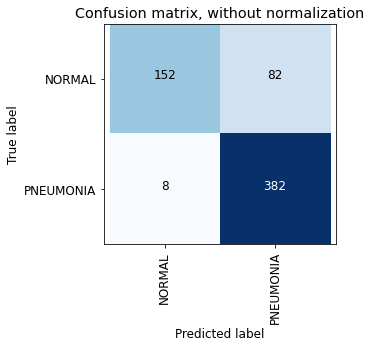

<Figure size 432x288 with 0 Axes>

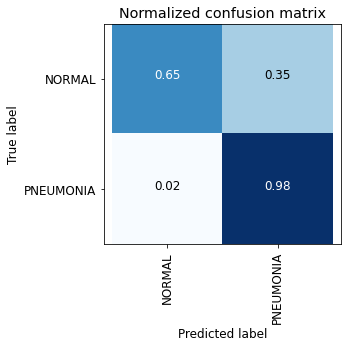

In [96]:
#@title confusion matrix
#@markdown https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html#sklearn.metrics.plot_confusion_matrix
class_names = classes
plt.rcParams.update({'font.size': 12})

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
    else:
#         print('Confusion matrix, without normalization')
        pass
#     print(cm)

    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    ax.axis('equal')
    plt.xticks(tick_marks, classes, rotation='vertical')
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrix
cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix and savefig
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix and savefig
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [97]:
#@title classification report
#@markdown https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html?highlight=classification_report#sklearn.metrics.classification_report

report = classification_report(y_test.argmax(axis=1), 
                               y_pred.argmax(axis=1), 
                               target_names=classes)
print(report)

              precision    recall  f1-score   support

      NORMAL       0.95      0.65      0.77       234
   PNEUMONIA       0.82      0.98      0.89       390

    accuracy                           0.86       624
   macro avg       0.89      0.81      0.83       624
weighted avg       0.87      0.86      0.85       624



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


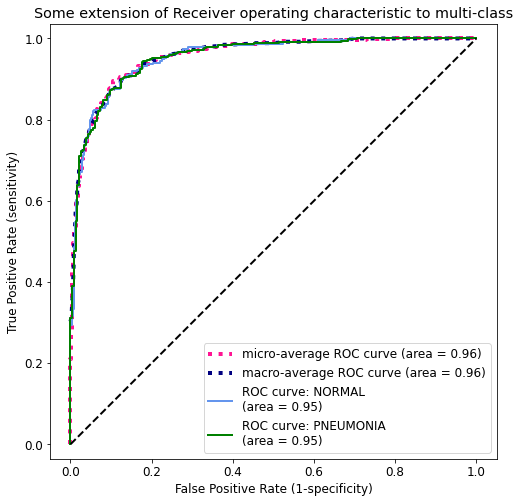

In [76]:
#@title ROC curve
#@markdown https://zh.wikipedia.org/zh-tw/ROC%E6%9B%B2%E7%BA%BF
micro_avg = True  #@param {type:"boolean"}
marco_avg = True  #@param {type:"boolean"}

N_CLASSES = len(classes)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(N_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

if micro_avg == True:
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

if marco_avg == True:
    # Compute macro-average ROC curve and ROC area
    
    lw = 2
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(N_CLASSES)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(N_CLASSES):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= N_CLASSES

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    

#### 畫出所有 ROC 曲線 ####
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

if micro_avg == True:
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

if marco_avg == True:
    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

colors = cycle(['cornflowerblue', 'green', 'darkorange', 'red'])
for i, color in zip(range(N_CLASSES), colors):
    ax.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve: {0}\n(area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

ax.plot([0, 1], [0, 1], 'k--', lw=lw)
ax.set(xlim=(0.0, 1.0), ylim=(0.0, 1.0))
ax.axis('equal')
ax.set_xlabel('False Positive Rate (1-specificity)')
ax.set_ylabel('True Positive Rate (sensitivity)')
ax.set_title('Some extension of Receiver operating characteristic to multi-class')
ax.legend(loc="lower right")
plt.show()